In [1]:
import scipy
import numpy             as np
import matplotlib.pyplot as plt

# CBF
from data      import make_rectangle, insert_shape, plot_data, get_gparams
from agent     import Agent
from optim     import get_learning_cbfs_lagrangian, get_h
from utils     import plot_cbf, quad_plot, union, intersection, difference
from controls  import hjb_controls, hjb_controls_parallel

# HJB
from   IPython.display      import HTML
import jax
import jax.numpy            as jnp
import matplotlib.animation as anim
import matplotlib.pyplot    as plt
import plotly.graph_objects as go
import hj_reachability      as hj

%load_ext autoreload
%autoreload 2

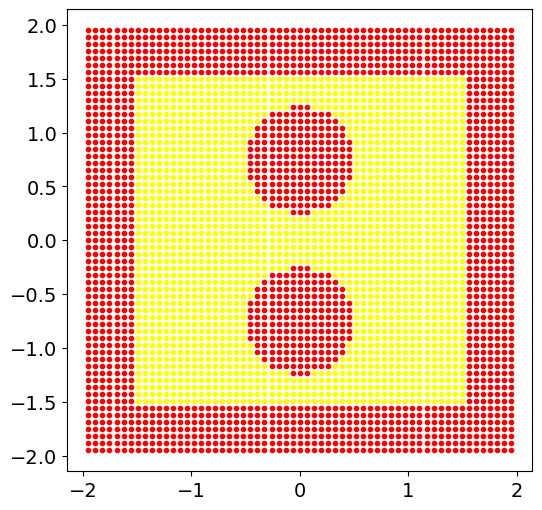

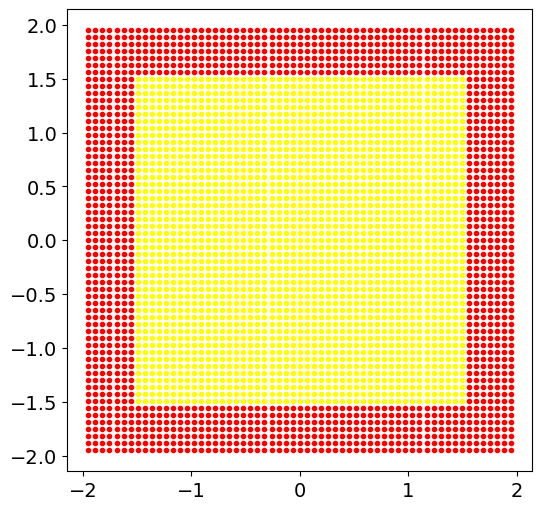

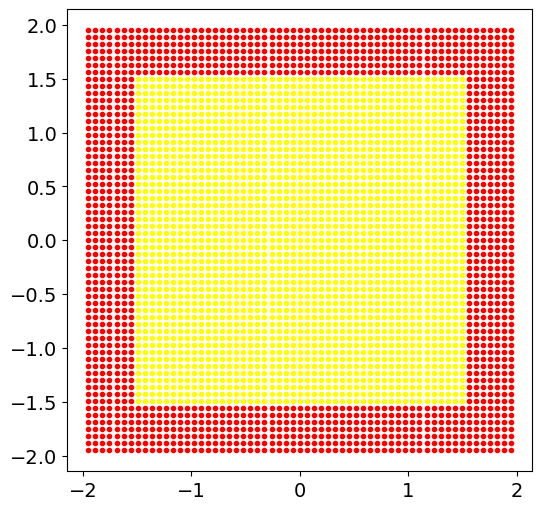

In [2]:
#########################
### Data Construction ###
#########################

# grid parameters
width         = 3
density       = 250
unsafe_margin = 0.3

# make grid and two circular obstacles, collect obstacle points
obs_funcs = []
grid, params, obs_dict, is_obs_grid = make_rectangle(height=width, width=width, density=density, unsafe_margin=unsafe_margin, center=(0,0), return_params=True)
obs_dict, is_obs_circ1  = insert_shape(np.array([0,  0.75]), grid, obs_dict, shape='circle', scale=0.5, theta=0)
obs_dict, is_obs_circ2  = insert_shape(np.array([0, -0.75]), grid, obs_dict, shape='circle', scale=0.5, theta=0)
obstacles = np.array([pt for pt in grid if obs_dict[tuple(np.round(pt, 3))] != 0])
obs_funcs.append(is_obs_grid)
obs_funcs.append(is_obs_circ1)
obs_funcs.append(is_obs_circ2)
_,_,_, spacing = params

# auxiliary grids 
c_grid, c_obs_dict = make_rectangle(height=width, width=width, density=density/1, unsafe_margin=unsafe_margin, center=(0,0))
s_grid, s_obs_dict = make_rectangle(height=width, width=width, density=density/1, unsafe_margin=unsafe_margin, center=(0,0)) # density of s_grid\
# should equal main grid density for set difference to work correctly

plot_data(  grid,   obs_dict, size=6)
plot_data(c_grid, c_obs_dict, size=6)
plot_data(s_grid, s_obs_dict, size=6)

In [173]:
###########################
### Agent Configuration ###
###########################

bf    = 31   # csrbf order
b     =-0.05  # offset 
s     = 0.66 # csrbf zeroing
nm    = 0.2  # nm * n_safe = number of neighbors to consider
p     = 0.5  # num neighber percentile under which boundary
mult  = 1
utype ='box' # defined w/ hjb above
umax  = 1    # defined w/ hjb above
solver        = 'CLARABEL'
sensor_radius = 1
rx            = sensor_radius + 0.2 # sample radius
rc            = sensor_radius # radius around scan in which centers are chosen
init_x        = 0
init_y        = 0
dynamics      = hj.systems.Planar(gamma=0, control_type=utype, umax=umax)

a = Agent(dynamics, np.array([init_x, init_y]), grid, obs_dict, width         = width, 
                                                                sensor_radius = sensor_radius, 
                                                                bf            = bf, 
                                                                b             = b, 
                                                                s             = s,
                                                                umax          = umax,
                                                                utype         = utype,
                                                                solver        = solver,
                                                                spacing       = spacing)

box constraints with umax 1


In [174]:
############################
### Scan for initial CBF ###
############################

# scan states 
pts_safe, pts_unsafe,\
             in_scan_f = a.scan(ret_in_scan_f=True) 
samples, is_obs_sample = a.sample(rx, grid=s_grid)

scan_funcs   = [in_scan_f]
sample_funcs = [is_obs_sample]

n_safe           = len(pts_safe)
x_buffer, x_safe = a.make_buffer(pts_safe, int(nm * n_safe), p)

# unsafe states 
if pts_unsafe.shape[0] != 0:
    x_unsafe = np.vstack((pts_unsafe, samples))
else: 
    x_unsafe = samples    

In [175]:
#######################
### Collect centers ###
#######################

C = []
for x in c_grid:
    if np.linalg.norm(x - a.pos) <= rc:
        C.append(x)
C = np.array(C)
a.centers.append(C)

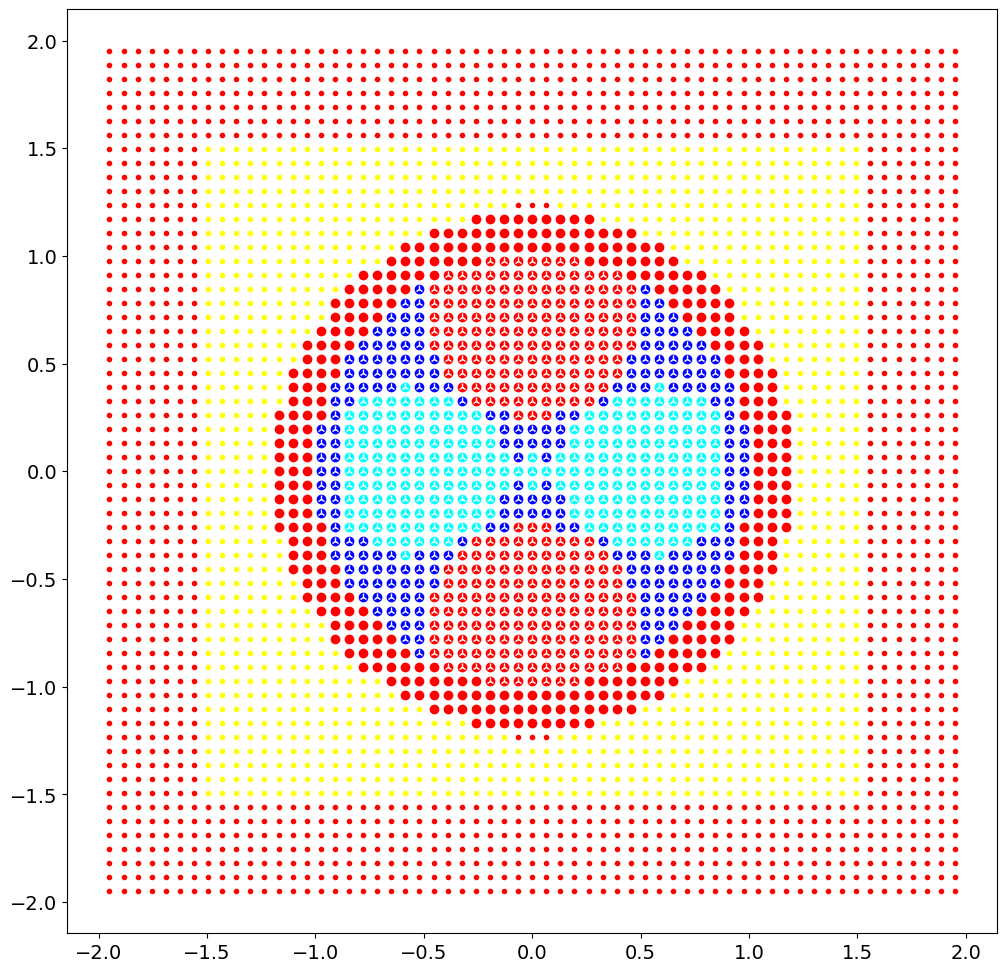

In [176]:
##############################
### Plot  Initial CBF Data ###
##############################

plot_data(grid, obs_dict, [(x_safe  , "cyan"  , 'o'), 
                           (x_buffer, "blue"  , 'o'), 
                           (x_unsafe, "red"   , 'o'),
                           (C       , "white" , '2')])

In [177]:
##############################
### Initial CBF Parameters ###
##############################
 
gamma_safe   = 0.3
gamma_unsafe =-0.01
gamma_dyn    = 0.01
lam_safe     = 25
lam_dyn      = 5
lam_unsafe   = 125
lam_dh       = 0.5
lam_sp       = 0

In [178]:
#########################
### Solve Initial CBF ###
#########################

# get h as a function of agent parameter
h = get_h(a)

#theta = np.array(clarabel_solve_cbf(a, x_safe, u_safe, x_buffer, u_buffer, x_unsafe, gamma_safe, gamma_dyn, gamma_unsafe))
L = get_learning_cbfs_lagrangian(a, x_safe, x_buffer, x_unsafe, lam_safe, lam_dyn, lam_unsafe, lam_dh, gamma_safe, gamma_dyn, gamma_unsafe)
theta, _, _ = scipy.optimize.fmin_l_bfgs_b(L, np.random.rand(C.shape[0], 1), approx_grad=False, iprint=50)

a.thetas.append(theta)
a.rectify_c_and_theta()

# initialize plotting objects
init_pos       = np.copy(a.pos)
curr_centers   = np.copy(np.array(a.centers))
curr_thetas    = np.copy(np.array(a.thetas))
curr_data      = np.copy(np.vstack((x_safe, x_buffer, x_unsafe)))
curr_traj      = np.copy(a.pos.reshape(-1, 2))
quad_plot_args =[(0, curr_centers, curr_thetas, curr_data)]
data_safe   = np.vstack((x_buffer, x_safe))
data_unsafe = x_unsafe
all_C = C

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          749     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.30011D+03    |proj g|=  4.55265D+01


 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   50    f=  9.45660D+02    |proj g|=  7.57103D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  749     65    148      2     0     0   8.539D-01   9.454D+02
  F =   945.37944618531401     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
centers shape before:
(749, 2)



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


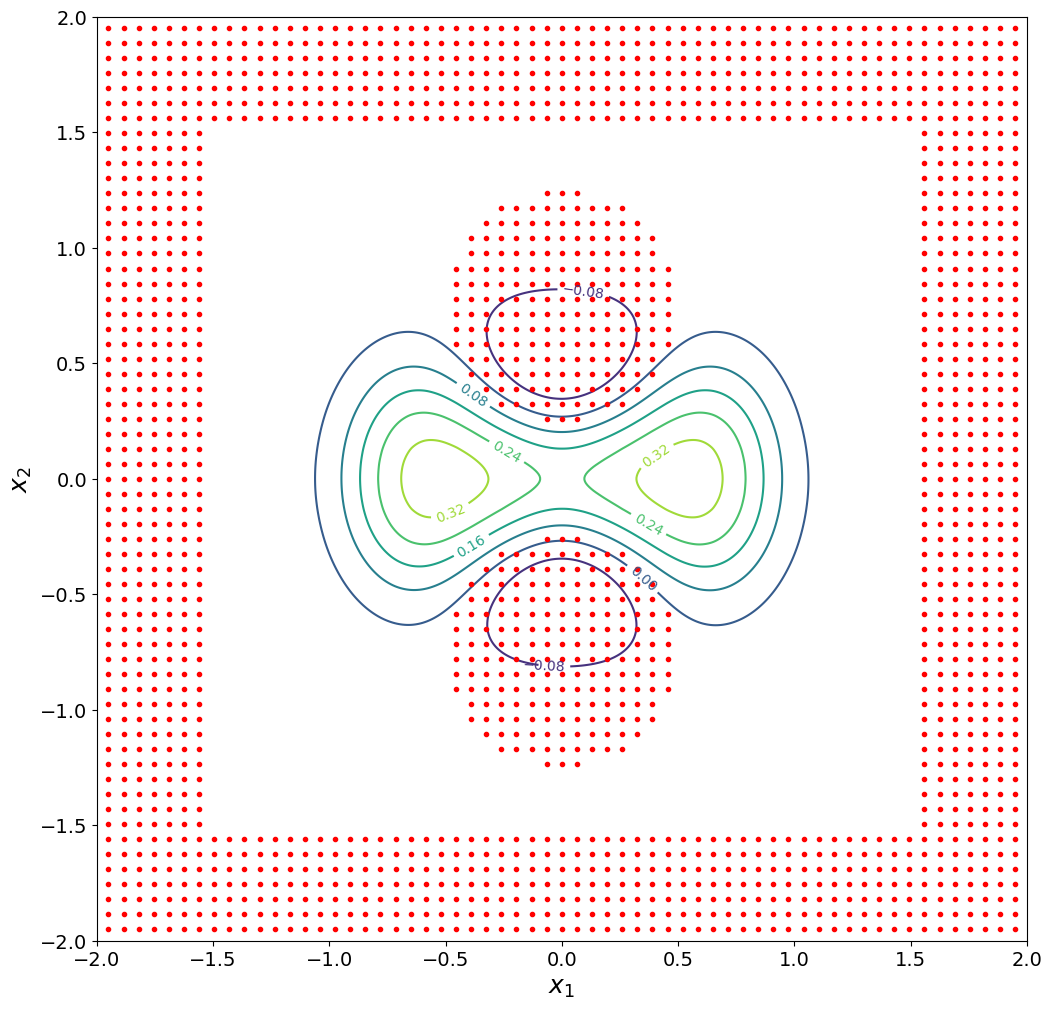

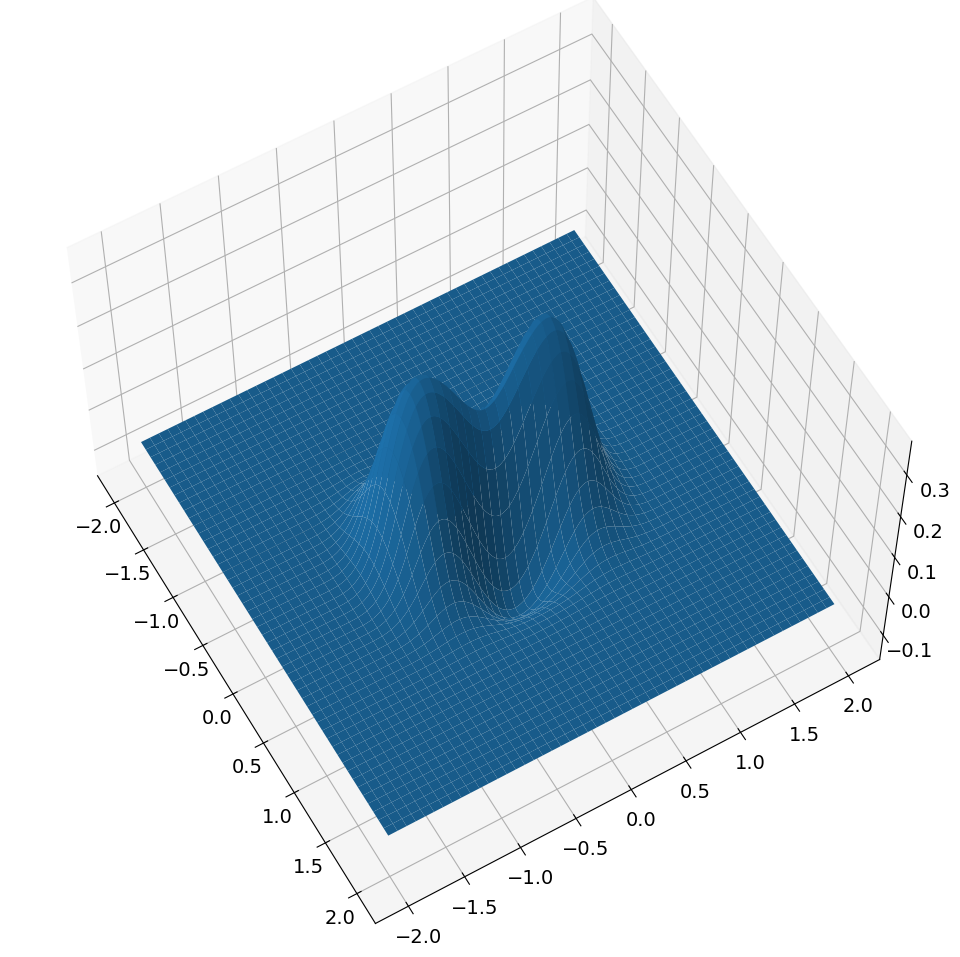

max h 0.3677478588118141


In [179]:
########################
### Plot Initial CBF ###
########################

h_max = plot_cbf(a, np.array(a.centers), np.array(a.thetas), obstacles=obstacles)

#plot_cbf(a, np.array(a.centers), np.array(a.thetas), obstacles=obstacles)

In [ ]:
##################################
### Configure Safe Exploration ###
##################################

DT   = 0.001   # numerical integration timestep
tol  = 0.29    # h-value at which to halt approach
eps  = 0
dx   = 0.5     # if |x'-x|<dx, approach again
tend = 20      # Duration of boundary approach
T    = 0.3     # MPC horizon (default timestep is 0.05)
N    = 3       # number of CBFs to learn

In [ ]:
########################
### Safe Exploration ###
########################

targets   = [np.array([ 1.1,  0]),
             np.array([ 1.1,  1]),
             np.array([ 1.1, -1]),
             np.array([-1.1,  0])]
#targets   = None

for i in range(N):
    ######################
    ### Go to boundary ###
    ######################
    
    prev_pos = a.pos  
    if targets is not None:
        print("target:", targets[i]) 
        traj = a.goto(targets[i], T=T, tend=tend, tol=tol, manual=True, DT=DT, eps=eps)  
        print("dx:", np.linalg.norm(a.pos - prev_pos))
    else: 
        while np.linalg.norm(a.pos - prev_pos) <= dx:    
            target = a.width*(1+unsafe_margin)*(np.random.rand(2)-0.5)  
            while h(target, np.array(a.centers), np.array(a.thetas))[0] > 0:
                target = a.width*(1+unsafe_margin)*(np.random.rand(2)-0.5)
            print("target:", target) 
            a.goto(target, T=T, tend=tend, tol=tol, manual=True, DT=DT, eps=eps) 
            print("dx:", np.linalg.norm(a.pos - prev_pos))

    ####################
    ### Collect data ###
    ####################

    # scan states 
    pts_safe, pts_unsafe, in_scan_f = a.scan(ret_in_scan_f=True)
    scan_funcs.append(in_scan_f)
    samples, gparams,\
             is_obs_sample = a.sample(rx, grid=s_grid, hjb_grid=hjb_grid, hjb=True)
    sample_funcs.append(is_obs_sample)
    loc_V, loc_hjb_grid    = a.get_local_V(gparams, obs_funcs + [is_obs_sample], rx=rx, T=500, mult=mult)
    scan_safe, scan_unsafe = a.scan_hjb(loc_V, loc_hjb_grid)
    n_safe                 = len(pts_safe)
    x_buffer, x_safe       = a.make_buffer(scan_safe, int(nm * n_safe), p)
    
    # unsafe states 
    if scan_unsafe.shape[0] != 0:
        x_unsafe = np.vstack((scan_unsafe, samples))
    else: 
        x_unsafe = samples    
        
    # centers
    C = []
    for x in c_grid:
        if np.linalg.norm(x - a.pos) <= rc:
            C.append(x)
    C = np.array(C)    
    a.centers.append(C)

    # plot CBF data
    plot_data(grid, obs_dict, [(x_safe  , "cyan"  , 'o'), 
                               (x_buffer, "blue"  , 'o'), 
                               (x_unsafe, "red"   , 'o'),
                               (C       , "white" , '2')])

    # safe and buffer control
    u_safe = hjb_controls_parallel(a, x_safe, loc_hjb_grid, loc_V, verbose=True)
    if x_buffer.shape[0] != 0:
        u_buffer = hjb_controls_parallel(a, x_buffer, loc_hjb_grid, loc_V)
    else:
        u_buffer = np.array([])

    # total data 
    from data import check_obs
    all_obs_func = lambda x: check_obs(x, obs_funcs) or (check_obs(x, sample_funcs) and not check_obs(x, scan_funcs))
    out_func     = lambda x: not ( check_obs(x, all_obs_func) or check_obs(x, scan_funcs) )
    obsamp_f     = lambda x: (check_obs(x, sample_funcs) or check_obs(x, obs_funcs)) and not (check_obs(x, scan_funcs) and not check_obs(x, obs_funcs))
    for x in grid:
        if obsamp_f(x):
            plt.plot(x[0], x[1], color='red', marker='o', linestyle='none')           
        else:
            plt.plot(x[0], x[1], color='black', marker='o', linestyle='none')
    plt.show()
 
    #####################
    ### Learn new CBF ###
    ##################### 
    #L = get_learning_cbfs_lagrangian_hj(a, x_safe, u_safe, x_buffer, u_buffer, x_unsafe, lam_safe, lam_dyn, lam_unsafe, lam_dh, gamma_safe, gamma_dyn, gamma_unsafe)
    #theta, _, _ = scipy.optimize.fmin_l_bfgs_b(L, 10*(np.random.rand(C.shape[0], 1)-5), approx_grad=False, iprint=50) 
    
    theta = np.array(clarabel_solve_cbf(a, x_safe, u_safe, x_buffer, u_buffer, x_unsafe, gamma_safe, gamma_dyn, gamma_unsafe))
    a.thetas.append(theta)
    a.rectify_c_and_theta()

    # plot new CBF
    h_max = plot_cbf(a, np.array(a.centers), np.array(a.thetas), obstacles=obstacles)

    # collect quad plot data
    curr_data    = np.copy(np.vstack( ( curr_data, np.vstack((x_safe, x_buffer, x_unsafe)) ) ))
    curr_centers = np.copy(np.array(a.centers))
    curr_thetas  = np.copy(np.array(a.thetas))
    curr_traj    = np.copy(np.vstack( (curr_traj, traj) ))
    quad_plot_args[-1] = quad_plot_args[-1] + (curr_traj,)
    quad_plot_args.append((i+1, curr_centers, curr_thetas, curr_data))

    data_safe   = union(data_safe, np.vstack((x_buffer, x_safe)))
    data_unsafe = difference(union(data_unsafe, x_unsafe), data_safe)
    all_C = union(all_C, C)
    
    plot_data(grid, obs_dict, [(data_safe  , "cyan"  , 'o'), 
                               (data_unsafe, "red"   , 'o'),
                               (all_C      , "white" , '2')])
    #plot_angle_data(all_C, grid, obs_dict, spacing, safe=data_safe, unsafe=data_unsafe, title="ALL DATA")

final_pos = np.copy(a.pos)
quad_plot_args[-1] = quad_plot_args[-1] + (curr_traj,)

In [ ]:
#######################################
### Sequential plot of learned CBFs ###
#######################################

fig = plt.figure(figsize=(15, 15))
axs = [fig.add_subplot(2,2,i+1) for i in range(4)]

for ax in axs:
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_aspect('equal') 
    
fig.subplots_adjust(wspace=0, hspace=0)

for i, args in enumerate(quad_plot_args):
    quad_plot(a, axs[i], args[0], args[1], args[2], args[3], args[4], grid, obs_dict, obstacles=obstacles)
plt.show()

In [ ]:
##################################################
### Learn a single CBF from all data collected ###
##################################################

n_safe = len(pts_safe)
all_obs_func = lambda x: (check_obs(x, sample_funcs) or check_obs(x, obs_funcs)) and not (check_obs(x, scan_funcs) and not check_obs(x, obs_funcs))
out_func     = lambda x: not ( check_obs(x, all_obs_func) or check_obs(x, scan_funcs) )
gparams = get_gparams(np.vstack((data_safe, data_unsafe)), hjb_grid)
loc_V, loc_hjb_grid = a.get_local_V(gparams, all_obs_func, rx=None, out_func=out_func, T=500, mult=mult)
print("number of gridpoints:", loc_hjb_grid.states.flatten().shape)
all_x_buffer, all_x_safe = a.make_buffer(data_safe, int(nm * n_safe), p) 
all_u_safe = hjb_controls_parallel(a, all_x_safe, loc_hjb_grid, loc_V, verbose=True)
if x_buffer.shape[0] != 0:
    all_u_buffer = hjb_controls_parallel(a, all_x_buffer, loc_hjb_grid, loc_V)
else:
    all_u_buffer = np.array([])
all_theta = np.array(clarabel_solve_cbf(a, all_x_safe, all_u_safe, all_x_buffer, all_u_buffer, data_unsafe, gamma_safe, gamma_dyn, gamma_unsafe, centers=all_C))
h_max = plot_cbf(a, np.array(all_C)[np.newaxis,...], np.array(all_theta)[np.newaxis,...])